**Explanable AI Approaches and Phishing Email Dataset**

I want to work on a text base dataset probably Phishing Email Detection (kaggle.com) and use XAI methods (LIME, SHAP, ...) to explain RandomForest results and I want to try to find a way to fool the model using explanations provided by XAI and also find ways to improve accuracy.

In [ ]:
#Installing LIME
try:
  import lime
except:
  print("Installing LIME")
  !pip install lime

In [8]:
#Importing modules
import sklearn
import pandas as pd
import sklearn.ensemble
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

**Phishing Email Dataset**

The dataset specifies the email text body the type of emails which can be used to detect phishing emails by extensive analytics of the email text and classifying those using machine learning

In [9]:
#Read data
df=pd.read_csv('Phishing_Email.csv')

In [10]:
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [11]:
df.tail()

,Unnamed: 0,Email Text,Email Type
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email
18649,18650,empty,Phishing Email


**Preprocessing**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


There is 16 null "Email Text"

In [13]:
#Remove null data
df = df.dropna(subset=['Email Text'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18634 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18634 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18634 non-null  object
dtypes: int64(1), object(2)
memory usage: 582.3+ KB


Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction.

In [15]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
#Remove stop words 
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Break it down into words
    text = [word for word in text if word not in stop_words]  # Remove stop words
    return ' '.join(text)


In [16]:
cleaned_emails = df['Email Text'].apply(clean_text)

In [17]:
cleaned_emails[:5]

0    6 1100 disc uniformitarianism 1086 sex lang di...
1    galicismos galicismo spanish term names improp...
2    equistar deal tickets available assist robert ...
3    hello hot lil horny toy dream open minded pers...
4    software incredibly low prices 86 lower draper...
Name: Email Text, dtype: object

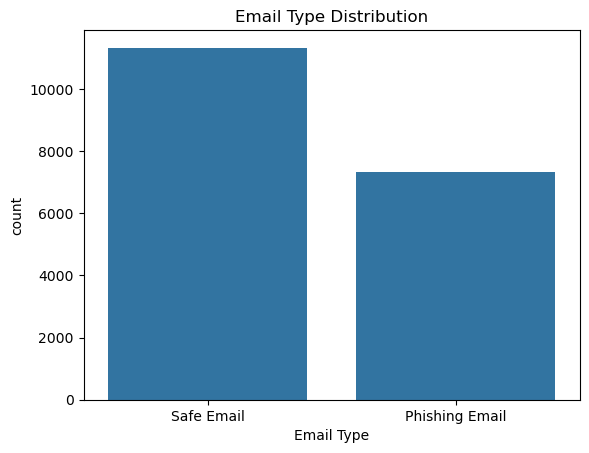

In [18]:
sns.countplot(x='Email Type', data=df)
plt.title('Email Type Distribution')
plt.show()

In [19]:
# Convert a target variable to boolean
y = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

In [ ]:
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(cleaned_emails, y, test_size=0.2, random_state=42)

Vectorize emails using TF-IDF vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Vectorize emails
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

labels are imbalance and we use oversampling techinque

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
print("Number of samples before over sampling :",X_train.shape)
# oversample
X_train, y_train = oversample.fit_resample(X_train, y_train)
print("Number of samples after over sampling :",X_train.shape)

**Model Training**

In [ ]:
#@title AutoML experiment: Random forest
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [ ]:
f1_score=sklearn.metrics.f1_score(y_test, pred, average='binary')
accuracy_score=sklearn.metrics.accuracy_score(y_test, pred)
print("f1-Score of random forest",f1_score)
print("accuracy of random forest",accuracy_score)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

In [ ]:
disp.plot(cmap='Blues')

**Explaining predictions using LIME**


In [ ]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(vectorizer, rf)

In [ ]:
i=3
print(cleaned_emails[i])
print(y[i])
print(pipeline.predict_proba([cleaned_emails[i]]))

In [ ]:
#Creating the LIME explainer
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Safe Email', 'Phishing Email'])


We then generate an explanation with at most 10 features for an arbitrary document in the test set.

In [ ]:
#Generating the explanation
idx=4
class_names = ['Safe Email', 'Phishing Email']
exp = explainer.explain_instance(cleaned_emails[idx], pipeline.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Probability(Phishing Email) =', pipeline.predict_proba([cleaned_emails[idx]])[0,1])
print('True class: %s' % class_names[y[idx]])

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. 

In [ ]:
#Explain as a list
exp.as_list()

In [ ]:
#Explaining with a plot
fig = exp.as_pyplot_figure()

 If we remove 'save' and 'low' from the document , the prediction should move towards the opposite class (Safe Email) by about 0.2 (the sum of the weights for both features). Let's see if this is the case.

In [ ]:
print('Original prediction: ', pipeline.predict_proba([cleaned_emails[idx]])[0,1])
tmp = cleaned_emails[idx]
tmp = tmp.replace('save','')
tmp = tmp.replace('low','')
print(tmp)
print('Prediction removing some features:', pipeline.predict_proba([tmp])[0,1])
print('Difference:', pipeline.predict_proba([tmp])[0,1] - pipeline.predict_proba([cleaned_emails[idx]])[0,1])

The words that affect the classifier in the text

In [ ]:
#Showing in notebook
exp.show_in_notebook(text=True)

In [ ]:
#@title Saving explanation
exp.save_to_file('oi.html')

Now, we want to fool this model using provided explanations

In [ ]:
i=3
print(cleaned_emails[i])
print(y[i])
print(pipeline.predict_proba([cleaned_emails[i]]))

This sample is Phishing based on prediction of our mode
and I want to add few positive word to change the result.

In [ ]:
exp = explainer.explain_instance(cleaned_emails[2], pipeline.predict_proba, num_features=10)
exp.as_list()

In [ ]:
print(pipeline.predict_proba([cleaned_emails[i] + "2000 pm thanks questions know deal cc forwarded"]))

We could change the result just by adding 8 words at the end of text and now our email is a "Safe Email" !!!!!!!

This is because our model used the TFIDF method to vectorize the data and does not pay attention to the position of the words in the sentence and their relationship with each other.

**Word Embedding**

Reapeat previous steps using Word Embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenize the text using TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # oov_token for out-of-vocabulary words
tokenizer.fit_on_texts(cleaned_emails)  # Fit tokenizer to the texts

In [ ]:
# Convert the text to sequences of tokens (integers)
sequences = tokenizer.texts_to_sequences(cleaned_emails)

In [ ]:
# Pad the sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)  # Pad up to a max length of 100

In [ ]:
# Build the embedding model
embedding_dim = 100  # Size of the embedding vector

# Define the embedding layer in TensorFlow
embedding_layer = tf.keras.layers.Embedding(input_dim=10000, output_dim=embedding_dim, input_length=100)

# Pass the padded sequences through the embedding layer
embeddings = embedding_layer(padded_sequences)

In [ ]:
# Print the embedding output (for example purposes, showing embeddings of first text)
print(f"Embedding shape: {embeddings.shape}")  # (batch_size, sequence_length, embedding_dim)
print(embeddings[0].numpy())  # Embeddings for the first text

In [ ]:
# Convert embeddings to numpy and average them to create a single vector for each text
# The output `embeddings` shape is (num_samples, sequence_length, embedding_dim)
# We take the mean across the sequence length to get a fixed-size vector for each sample
averaged_embeddings = tf.reduce_mean(embeddings, axis=1).numpy()  # Shape: (num_samples, embedding_dim)
averaged_embeddings.shape

In [ ]:
# Split the data into train and test sets
emb_X_train, emb_X_test, emb_y_train, emb_y_test = train_test_split(averaged_embeddings, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
print("Number of samples before over sampling :",emb_X_train.shape)
# oversample
emb_X_train, emb_y_train = oversample.fit_resample(emb_X_train, emb_y_train)
print("Number of samples after over sampling :",emb_X_train.shape)

In [ ]:
# Train a Random Forest Classifier
emb_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
emb_rf.fit(emb_X_train, emb_y_train)

# Make predictions on the test set
emb_y_pred = emb_rf.predict(emb_X_test)

In [ ]:
f1_score=sklearn.metrics.f1_score(emb_y_test, emb_y_pred, average='binary')
accuracy_score=sklearn.metrics.accuracy_score(emb_y_test, emb_y_pred)
print("f1-Score of random forest",f1_score)
print("accuracy of random forest",accuracy_score)

In [ ]:
#Creating the LIME explainer
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Safe Email', 'Phishing Email'])

In [ ]:
def emb_pred(data):
    # Convert the text to sequences of tokens (integers)
    sequences = tokenizer.texts_to_sequences(data)
    # Pad the sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)  # Pad up to a max length of 100
    # Pass the padded sequences through the embedding layer
    embeddings = embedding_layer(padded_sequences)
    averaged_embeddings = tf.reduce_mean(embeddings, axis=1).numpy()  # Shape: (num_samples, embedding_dim)
    y_pred = emb_rf.predict_proba(averaged_embeddings)
    return y_pred

In [ ]:
#Generating the explanation
idx=4
class_names = ['Safe Email', 'Phishing Email']
exp = explainer.explain_instance(cleaned_emails[idx], emb_pred, num_features=10)
print('Document id: %d' % idx)
print('Probability(Phishing Email) =', emb_pred([cleaned_emails[idx]])[0,1])
print('True class: %s' % class_names[y[idx]])

In [ ]:
#Showing in notebook
exp.show_in_notebook(text=True)

In [ ]:
i=3
print(cleaned_emails[i])
print(y[i])
print(emb_pred([cleaned_emails[i]]))

In [ ]:
print(emb_pred([cleaned_emails[i] + "2000 pm thanks questions know deal cc forwarded"]))

The use of Word embedding could not improve our model, it seems that it is better to use other models such as RNN, LSTM, etc. to improve the result.

**Use LSTM**


In [1]:
import tensorflow as tf

# Disable all GPU devices
tf.config.set_visible_devices([], 'GPU')


In [48]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU

# Load your CSV file into a DataFrame
data = pd.read_csv('Phishing_Email.csv')  # Replace with the actual path to your CSV

#Remove null data
data = data.dropna(subset=['Email Text'])# Separate the features (text) and labels

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
#Remove stop words 
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Break it down into words
    text = [word for word in text if word not in stop_words]  # Remove stop words
    return ' '.join(text)


texts = data['Email Text'].apply(clean_text).values  # Text data
labels = data['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1}).values  # Labels (0 or 1 for binary classification)

# Parameters
max_features = 10000  # Maximum number of words to keep in the tokenizer
maxlen = 100  # Maximum length of sequences (texts will be padded or truncated)
embedding_dim = 128  # Dimension of the word embedding

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to ensure they are of the same length
X = pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so sigmoid output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 3
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test score: {score}")
print(f"Test accuracy: {acc}")

# Make predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
print(predictions)


Epoch 1/3
258/466 [===============>..............] - ETA: 17s - loss: 0.2151 - accuracy: 0.9087

KeyboardInterrupt: 

In [49]:
#Creating the LIME explainer
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Safe Email', 'Phishing Email'])

In [50]:
import numpy as np
def lstm_pred(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=maxlen)
    arr = np.array([1-model.predict(X),model.predict(X)])
    return np.hstack([arr[0], arr[1]])

In [51]:
#Generating the explanation
idx=4
class_names = ['Safe Email', 'Phishing Email']
exp = explainer.explain_instance(cleaned_emails[idx], lstm_pred, num_features=10)
print('Document id: %d' % idx)
print('Probability(Phishing Email) =', lstm_pred([cleaned_emails[idx]])[0,1])
print('True class: %s' % class_names[y[idx]])

Document id: 4
Probability(Phishing Email) = 0.9252008
True class: Phishing Email


In [52]:
i=3
print(cleaned_emails[i])
print(y[i])
print(lstm_pred([cleaned_emails[i]]))

hello hot lil horny toy dream open minded person love talk subject fantasy way life ultimate sex play ummmmmmmmmmmmmm wet ready looks imagination matters sexy voice make dream come true hurry let cummmmm toll free 1 877 451 teen 1 877 451 8336 phone billing 1 900 993 2582 _______________________________________________ sign free personalized e mail mail com http www mail com sr signup
1
[[0.00872552 0.9912745 ]]


In [61]:
print(lstm_pred([cleaned_emails[i] + "2000 pm thanks questions know deal cc forwarded"]))

[[0.73875886 0.26124114]]
